## Preparing environment

In [1]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPRegressor
from category_encoders.cat_boost import CatBoostEncoder
from tqdm import tqdm
from catboost import CatBoostRegressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

data_path = "./data"

In [2]:
seed = 42

np.random.seed(seed)

## Data processing

In [3]:
# reading data
data_dsc = pd.read_csv(os.path.join(data_path, "data_dsc.csv"))
data_dsc = data_dsc.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])
data_fp = pd.read_csv(os.path.join(data_path, "data_fp.csv"))
data_fp = data_fp.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])
data_2d = pd.read_csv(os.path.join(data_path, "data_2d.csv"))
data_2d = data_2d.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])

In [4]:
# deleting duplicate columns
data = pd.concat([data_dsc, data_fp, data_2d], axis=1)
data = data.loc[:, ~data.columns.duplicated()].copy()
data.shape

(36377, 2264)

In [5]:
X = data.drop(columns=["IC50"])
y = data["IC50"]

In [6]:
# deleting columns with 1 unique value
useless_columns = list()

for column in tqdm(X.columns):
    if X[column].unique().shape[0] == 1:
        useless_columns.append(column)

X = X.drop(columns=useless_columns)
len(useless_columns)

100%|██████████| 2263/2263 [00:00<00:00, 7307.57it/s]


7

In [7]:
need_to_fill_columns = list()

for column in X.columns:
    if X[column].isnull().any():
        need_to_fill_columns.append(column)

print(len(need_to_fill_columns))

12


In [8]:
# filling nans
imputer = SimpleImputer(strategy='mean')
X[need_to_fill_columns] = imputer.fit_transform(X[need_to_fill_columns])

### Feature engineering

In [9]:
X["TitleLen"] = X["Title"].apply(lambda x: len(x))
X["SMILESLen"] = X["SMILES"].apply(lambda x: len(x))

In [10]:
def get_first_number(s):
    number = str()
    flag = False
    for c in s:
        if c.isnumeric():
            number += c
            flag = True
        elif flag:
            break
    return int(number)

def get_first_str(s):
    first_str = str()
    flag = False
    for c in s:
        if c.isalpha():
            first_str += c
            flag = True
        elif flag:
            break
    return first_str

In [11]:
X["FirstNumTitle"] = X["Title"].apply(get_first_number)
# X["FirstStrTitle"] = X["Title"].apply(get_first_str)

### Last preparation

In [12]:
text_features = ["Title", "SMILES"]

In [13]:
cat_features = list()

for column, dtype in X.dtypes.to_dict().items():
    if column in text_features:
        continue
    elif dtype == "object":
        cat_features.append(column)
    elif X[column].dtype == int and X[column].unique().shape[0] < 10:
        cat_features.append(column)

len(cat_features)

2122

### Few graphs

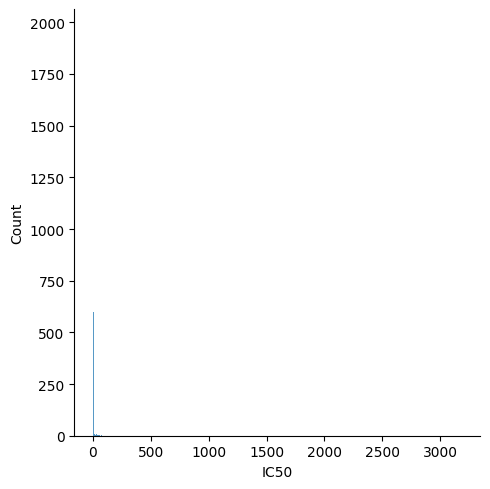

In [14]:
sns.displot(y)
plt.show()

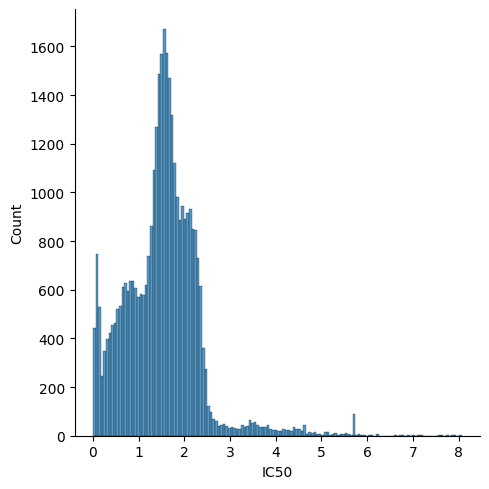

In [15]:
sns.displot(np.log1p(y))
plt.show()

In [16]:
# logarithm target
y = np.log1p(y)

## Models

### CatBoost

In [17]:
def title_catboost_processing(title):
    new_title = str()
    for s in title:
        if s.isdigit():
            new_title += f' {s}'
        else:
            new_title += s
    return new_title

In [18]:
X_copy = X.copy()
y_copy = y.copy()

# Processing text features
# Splitting numbers in title by spaces (to create  separate tokens)
X_copy["Title"] = X_copy["Title"].apply(title_catboost_processing)
X_copy["SMILES"] = X_copy["SMILES"].apply(lambda x: ' '.join(list(x)))

X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)

In [19]:
cb_model = CatBoostRegressor(
    iterations=1500,
    text_features=text_features,
    cat_features=cat_features,
    eval_metric="R2",
    learning_rate=0.18,
    verbose=100,
    use_best_model=True,
    early_stopping_rounds=300,
)

cb_model.fit(X_train, y_train, eval_set=(X_val, y_val))

preds = cb_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

0:	learn: 0.0529471	test: 0.0529239	best: 0.0529239 (0)	total: 89.6ms	remaining: 2m 14s
100:	learn: 0.4261791	test: 0.3072824	best: 0.3073405 (99)	total: 5.51s	remaining: 1m 16s
200:	learn: 0.4985548	test: 0.3210178	best: 0.3211280 (198)	total: 10.8s	remaining: 1m 10s
300:	learn: 0.5487301	test: 0.3276013	best: 0.3278197 (298)	total: 16.4s	remaining: 1m 5s
400:	learn: 0.5855055	test: 0.3290729	best: 0.3290729 (400)	total: 22s	remaining: 1m
500:	learn: 0.6157673	test: 0.3322221	best: 0.3322221 (500)	total: 27.5s	remaining: 54.8s
600:	learn: 0.6436404	test: 0.3299065	best: 0.3323205 (506)	total: 33.1s	remaining: 49.5s
700:	learn: 0.6659777	test: 0.3322740	best: 0.3326228 (683)	total: 38.6s	remaining: 44s
800:	learn: 0.6893619	test: 0.3311811	best: 0.3326228 (683)	total: 44.2s	remaining: 38.5s
900:	learn: 0.7109825	test: 0.3320474	best: 0.3326228 (683)	total: 49.8s	remaining: 33.1s
1000:	learn: 0.7292631	test: 0.3323854	best: 0.3328780 (957)	total: 55.4s	remaining: 27.6s
1100:	learn: 0.74

0.12657950777752613

### CatBoost permutation importance

In [20]:
cb_importances_name = "cb_importances.json"

if not os.path.isfile(cb_importances_name):

    importance = permutation_importance(cb_model, X_val, y_val, scoring="r2", n_repeats=5, random_state=seed, n_jobs=-1)
    for k, v in importance.items():
        importance[k] = v.tolist()

    with open(cb_importances_name, "w") as fp:
        json.dump(importance, fp=fp)

In [21]:
with open(cb_importances_name, "r") as fp:
    importance = json.load(fp)

In [22]:
stay_cb_importance_columns = list()
drop_cb_importance_columns = list()

threshold = 1e-3

for i, v in enumerate(importance["importances_mean"]):
    if v > threshold:
        stay_cb_importance_columns.append(X_val.columns[i])
    else:
        drop_cb_importance_columns.append(X_val.columns[i])

print(len(stay_cb_importance_columns))

44


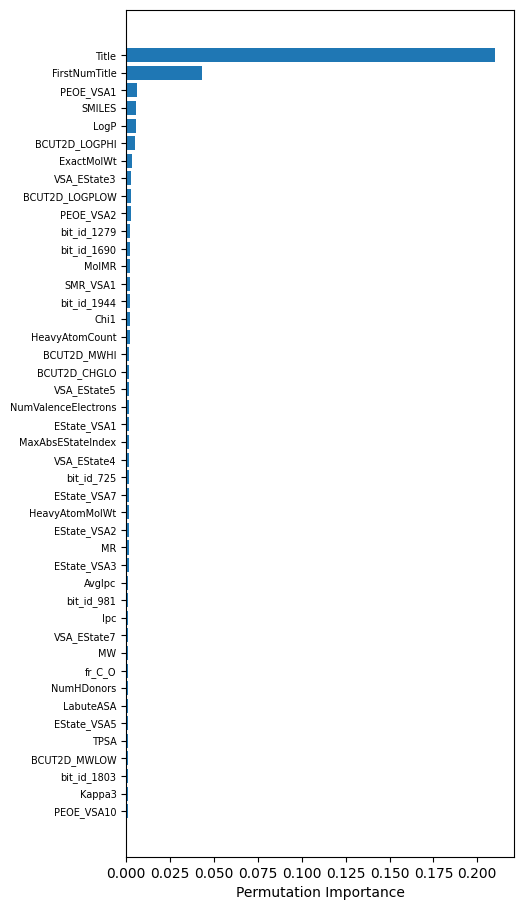

In [23]:
barh_dict = dict()

for i, v in enumerate(importance["importances_mean"]):
    if v > threshold:
        # print(f'Feature: {X_val.columns[i]}, Score: {v:.5f}')
        barh_dict[X_val.columns[i]] = v

barh_dict = {k: v for k, v in sorted(barh_dict.items(), key=lambda item: item[1])}

plt.figure(figsize=(5, 11))
plt.barh(barh_dict.keys(), barh_dict.values())
plt.yticks(fontsize=7)
plt.xlabel('Permutation Importance')
plt.show()

### CatBoost with PI

In [24]:
X_copy = X.copy()
y_copy = y.copy()
X_copy = X_copy[stay_cb_importance_columns]
X_copy["Title"] = X_copy["Title"].apply(title_catboost_processing)
X_copy["SMILES"] = X_copy["SMILES"].apply(lambda x: ' '.join(list(x)))

X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)

In [25]:
cb_model = CatBoostRegressor(
    iterations=1500,
    text_features=[feature for feature in text_features if feature not in drop_cb_importance_columns],
    cat_features=[feature for feature in cat_features if feature not in drop_cb_importance_columns],
    eval_metric="R2",
    learning_rate=0.2,
    verbose=100,
    use_best_model=True,
    early_stopping_rounds=600,
)

cb_model.fit(X_train, y_train, eval_set=(X_val, y_val))

preds = cb_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

0:	learn: 0.0656065	test: 0.0679731	best: 0.0679731 (0)	total: 5.43ms	remaining: 8.14s
100:	learn: 0.4263388	test: 0.3160007	best: 0.3161251 (99)	total: 613ms	remaining: 8.49s
200:	learn: 0.4897471	test: 0.3244925	best: 0.3250260 (187)	total: 1.21s	remaining: 7.83s
300:	learn: 0.5371519	test: 0.3244191	best: 0.3250260 (187)	total: 1.81s	remaining: 7.23s
400:	learn: 0.5735273	test: 0.3256627	best: 0.3259908 (391)	total: 2.42s	remaining: 6.63s
500:	learn: 0.6062778	test: 0.3256159	best: 0.3260126 (407)	total: 3.03s	remaining: 6.04s
600:	learn: 0.6350152	test: 0.3263161	best: 0.3267334 (593)	total: 3.64s	remaining: 5.45s
700:	learn: 0.6622822	test: 0.3246734	best: 0.3268579 (634)	total: 4.26s	remaining: 4.85s
800:	learn: 0.6866214	test: 0.3239990	best: 0.3268579 (634)	total: 4.88s	remaining: 4.25s
900:	learn: 0.7092150	test: 0.3222624	best: 0.3268579 (634)	total: 5.49s	remaining: 3.65s
1000:	learn: 0.7279791	test: 0.3205037	best: 0.3268579 (634)	total: 6.11s	remaining: 3.04s
1100:	learn: 

0.1331607758006419

### CatBoost with PI & SVD

In [26]:
X_copy = X.copy()
y_copy = y.copy()
X_copy["Title"] = X_copy["Title"].apply(title_catboost_processing)
X_copy["SMILES"] = X_copy["SMILES"].apply(lambda x: ' '.join(list(x)))

X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)

In [27]:
svd_n_components = 16
svd = TruncatedSVD(n_components=svd_n_components, algorithm="randomized", random_state=seed)
svd.fit(X_train[drop_cb_importance_columns])

train_emb = pd.DataFrame(svd.transform(X_train[drop_cb_importance_columns]), columns=[f"emb_{i}"for i in range(svd_n_components)], index=X_train.index)
X_train = pd.concat([X_train[stay_cb_importance_columns], train_emb], axis=1)

val_emb = pd.DataFrame(svd.transform(X_val[drop_cb_importance_columns]), columns=[f"emb_{i}"for i in range(svd_n_components)], index=X_val.index)
X_val = pd.concat([X_val[stay_cb_importance_columns], val_emb], axis=1)

In [28]:
cb_model = CatBoostRegressor(
    iterations=2000,
    text_features=[feature for feature in text_features if feature not in drop_cb_importance_columns],
    cat_features=[feature for feature in cat_features if feature not in drop_cb_importance_columns],
    eval_metric="R2",
    learning_rate=0.12,
    verbose=100,
    use_best_model=True,
    early_stopping_rounds=600,
)

cb_model.fit(X_train, y_train, eval_set=(X_val, y_val))

preds = cb_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

0:	learn: 0.0392860	test: 0.0390780	best: 0.0390780 (0)	total: 5.68ms	remaining: 11.4s
100:	learn: 0.3887793	test: 0.3085388	best: 0.3085388 (100)	total: 680ms	remaining: 12.8s
200:	learn: 0.4511796	test: 0.3233923	best: 0.3233923 (200)	total: 1.34s	remaining: 12s
300:	learn: 0.4939177	test: 0.3275925	best: 0.3279311 (272)	total: 2s	remaining: 11.3s
400:	learn: 0.5287999	test: 0.3306824	best: 0.3306824 (400)	total: 2.69s	remaining: 10.7s
500:	learn: 0.5580316	test: 0.3301905	best: 0.3311565 (437)	total: 3.38s	remaining: 10.1s
600:	learn: 0.5856102	test: 0.3309486	best: 0.3313147 (580)	total: 4.06s	remaining: 9.46s
700:	learn: 0.6086952	test: 0.3315550	best: 0.3316859 (693)	total: 4.75s	remaining: 8.79s
800:	learn: 0.6309925	test: 0.3316327	best: 0.3322108 (748)	total: 5.43s	remaining: 8.13s
900:	learn: 0.6516834	test: 0.3330562	best: 0.3335060 (894)	total: 6.11s	remaining: 7.46s
1000:	learn: 0.6716826	test: 0.3332213	best: 0.3336196 (956)	total: 6.8s	remaining: 6.78s
1100:	learn: 0.689

0.13430790291159544 0.12 16

### CatBoost PI without text features

In [19]:
X_copy = X.copy()
y_copy = y.copy()
X_copy = X_copy.drop(columns=text_features)

X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)

In [30]:
cb_model = CatBoostRegressor(
    iterations=1500,
    cat_features=[feature for feature in cat_features if feature not in drop_cb_importance_columns],
    eval_metric="R2",
    learning_rate=0.11,
    verbose=100,
    use_best_model=True,
    early_stopping_rounds=600,
)

cb_model.fit(X_train, y_train, eval_set=(X_val, y_val))

preds = cb_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

0:	learn: 0.0292284	test: 0.0297728	best: 0.0297728 (0)	total: 16.7ms	remaining: 25s
100:	learn: 0.3829543	test: 0.2987035	best: 0.2987035 (100)	total: 1.3s	remaining: 18s
200:	learn: 0.4553399	test: 0.3203914	best: 0.3203914 (200)	total: 2.56s	remaining: 16.5s
300:	learn: 0.5033791	test: 0.3293219	best: 0.3293219 (300)	total: 3.84s	remaining: 15.3s
400:	learn: 0.5405575	test: 0.3347311	best: 0.3347311 (400)	total: 5.12s	remaining: 14s
500:	learn: 0.5714360	test: 0.3378446	best: 0.3378855 (499)	total: 6.39s	remaining: 12.7s
600:	learn: 0.5981039	test: 0.3393139	best: 0.3395213 (596)	total: 7.66s	remaining: 11.5s
700:	learn: 0.6217746	test: 0.3395707	best: 0.3399771 (676)	total: 8.93s	remaining: 10.2s
800:	learn: 0.6433532	test: 0.3408154	best: 0.3408566 (799)	total: 10.2s	remaining: 8.92s
900:	learn: 0.6629165	test: 0.3419612	best: 0.3420344 (890)	total: 11.5s	remaining: 7.64s
1000:	learn: 0.6800960	test: 0.3421752	best: 0.3424584 (972)	total: 12.8s	remaining: 6.37s
1100:	learn: 0.6962

0.12335068680135974

In [20]:
cb_importances_name = "cb_importances_wo_text.json"

if not os.path.isfile(cb_importances_name):

    importance = permutation_importance(cb_model, X_val, y_val, scoring="r2", n_repeats=5, random_state=seed, n_jobs=-1)
    for k, v in importance.items():
        importance[k] = v.tolist()

    with open(cb_importances_name, "w") as fp:
        json.dump(importance, fp=fp)

In [21]:
with open(cb_importances_name, "r") as fp:
    importance = json.load(fp)

In [22]:
stay_cb_importance_columns = list()
drop_cb_importance_columns = list()

threshold = 1e-3

for i, v in enumerate(importance["importances_mean"]):
    if v > threshold:
        stay_cb_importance_columns.append(X_val.columns[i])
    else:
        drop_cb_importance_columns.append(X_val.columns[i])

print(len(stay_cb_importance_columns))

40


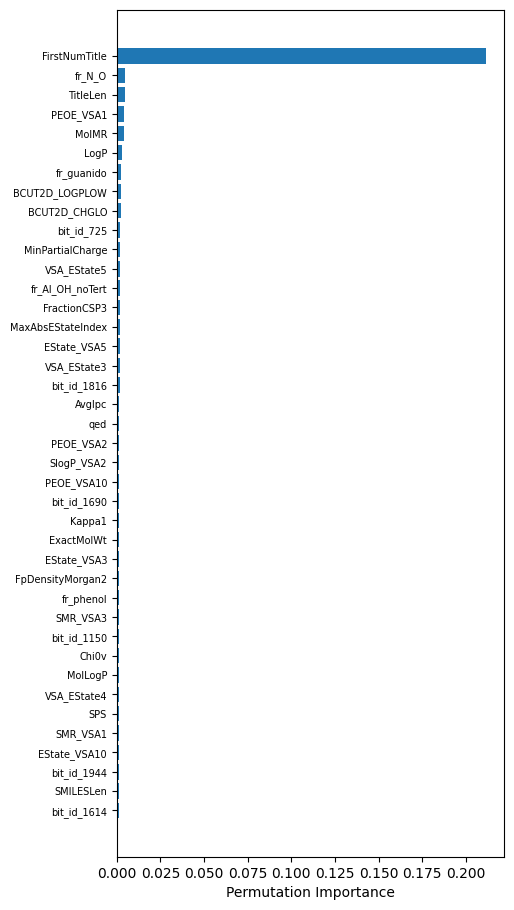

In [23]:
barh_dict = dict()

for i, v in enumerate(importance["importances_mean"]):
    if v > threshold:
        # print(f'Feature: {X_val.columns[i]}, Score: {v:.5f}')
        barh_dict[X_val.columns[i]] = v

barh_dict = {k: v for k, v in sorted(barh_dict.items(), key=lambda item: item[1])}

plt.figure(figsize=(5, 11))
plt.barh(barh_dict.keys(), barh_dict.values())
plt.yticks(fontsize=7)
plt.xlabel('Permutation Importance')
plt.show()

### LinearRegression

In [28]:
X_copy = X.copy()
y_copy = y.copy()

X_copy = X_copy.drop(columns=text_features)
X_copy[cat_features] = X_copy[cat_features].astype(str)

X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)

cb_encoder = CatBoostEncoder(random_state=seed)
X_train[cat_features] = cb_encoder.fit_transform(X_train[cat_features], y_train)
X_val[cat_features] = cb_encoder.transform(X_val[cat_features])

In [ ]:
linreg_model = LinearRegression(n_jobs=-1)
linreg_model.fit(X_train, y_train)

preds = linreg_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

R2: -0.00736758865185605


### LinearRegression with PI

In [37]:
X_train = X_train.drop(columns=drop_cb_importance_columns)
X_val = X_val.drop(columns=drop_cb_importance_columns)

In [38]:
linreg_model = LinearRegression(n_jobs=-1)
linreg_model.fit(X_train, y_train)

preds = linreg_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

R2: -0.002981317241136594


### RandomForest

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)
X_train[cat_features] = cb_encoder.transform(X_train[cat_features])
X_val[cat_features] = cb_encoder.transform(X_val[cat_features])

In [ ]:
rf_model = RandomForestRegressor(n_estimators=96, random_state=seed, n_jobs=-1)

rf_model.fit(X_train, y_train)

preds = rf_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

### RandomForest with PI

In [41]:
X_train = X_train.drop(columns=drop_cb_importance_columns)
X_val = X_val.drop(columns=drop_cb_importance_columns)

In [42]:
rf_model = RandomForestRegressor(n_estimators=96, random_state=seed, n_jobs=-1)

rf_model.fit(X_train, y_train)

preds = rf_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

R2: 0.09935978301446813


### ExtraTreesRegressor

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)
X_train[cat_features] = cb_encoder.transform(X_train[cat_features])
X_val[cat_features] = cb_encoder.transform(X_val[cat_features])

In [38]:
et_model = ExtraTreesRegressor(n_estimators=48, random_state=seed, n_jobs=-1)

et_model.fit(X_train, y_train)

preds = et_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

R2: 0.09781962070036554


### ExtraTreesRegressor with PI

In [44]:
X_train = X_train.drop(columns=drop_cb_importance_columns)
X_val = X_val.drop(columns=drop_cb_importance_columns)

In [45]:
et_model = ExtraTreesRegressor(n_estimators=48, random_state=seed, n_jobs=-1)

et_model.fit(X_train, y_train)

preds = et_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

R2: 0.10315571283193614


### MLP with PI

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)
X_train[cat_features] = cb_encoder.transform(X_train[cat_features])
X_val[cat_features] = cb_encoder.transform(X_val[cat_features])

In [30]:
X_train = X_train.drop(columns=drop_cb_importance_columns)
X_val = X_val.drop(columns=drop_cb_importance_columns)

In [31]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train.to_numpy()).float(),
                                               torch.from_numpy(y_train.to_numpy()).float(),)
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val.to_numpy()).float(),
                                             torch.from_numpy(y_val.to_numpy()).float(),)

In [32]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [33]:
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(40, 32),
            nn.Sigmoid(),
            nn.Linear(32, 16),
            nn.Sigmoid(),
            nn.Linear(16, 1),
        )

    def forward(self,x):
        x = self.linear(x)

        return x

In [50]:
model = mlp()

lr = 1e-3
epochs = 100

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criteon = nn.MSELoss()

In [51]:
for epoch in range(epochs):
    losses = list()
    model.train()
    for step, (x, y) in enumerate(train_dataloader):
        output = model(x)
        output = output.view(output.shape[0])
        loss = criteon(output, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    if epoch % 10 == 0:
        print(f"train loss = {np.mean(losses)}")

    model.eval()
    all_labels = list()
    all_preds = list()
    with torch.inference_mode():
        for step, (x, y) in enumerate(val_dataloader):
            output = model(x)
            output = output.view(output.shape[0])
            all_labels.extend(y.tolist())
            all_preds.extend(output.tolist())
    if epoch % 10 == 0:
        print(f"R2 = {r2_score(np.expm1(all_labels), np.expm1(all_preds))}")

train loss = 0.7037664378082359
R2 = -0.006775932504937687
train loss = 0.680047021986364
R2 = -0.00657358754079862
train loss = 0.6812987554859329
R2 = -0.0070009275208084976
train loss = 0.6812359515782241
R2 = -0.007625286574364454
train loss = 0.6810497654008342
R2 = -0.007400871835200551
train loss = 0.6812710102442857
R2 = -0.0068647221076980625
train loss = 0.6809459662699437
R2 = -0.007039125717026362
train loss = 0.6814167967864445
R2 = -0.006663324110535607
train loss = 0.6809374827605027
R2 = -0.0067273219624754965
train loss = 0.6807371781422542
R2 = -0.007681828049407979


### conv1d

In [52]:
class conv_net(nn.Module):
    def __init__(self):
        super(conv_net, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2),
            nn.Sigmoid(),
            nn.Conv1d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2),
            nn.Sigmoid(),
        )

        self.linear = nn.Sequential(
            nn.Linear(80, 32),
            nn.Sigmoid(),
            nn.Linear(32, 1),

        )


    def forward(self,x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)

        return x

In [57]:
model = conv_net()

lr = 1e-2
epochs = 200

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criteon = nn.MSELoss()

In [58]:
for epoch in range(epochs):
    losses = list()
    model.train()
    for step, (x, y) in enumerate(train_dataloader):
        output = model(x)
        output = output.view(output.shape[0])
        loss = criteon(output, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    if epoch % 10 == 0:
        print(f"train loss = {np.mean(losses)}")

    model.eval()
    all_labels = list()
    all_preds = list()
    with torch.inference_mode():
        for step, (x, y) in enumerate(val_dataloader):
            output = model(x)
            output = output.view(output.shape[0])
            all_labels.extend(y.tolist())
            all_preds.extend(output.tolist())
    if epoch % 10 == 0:
        print(f"R2 = {r2_score(np.expm1(all_labels), np.expm1(all_preds))}")

train loss = 0.6971908120663611
R2 = -0.006614391563005917
train loss = 0.6165519079664251
R2 = -0.004316600474695953
train loss = 0.6065938341093587
R2 = -0.0002539484803960601
train loss = 0.598645224414029
R2 = 0.003923685954364653
train loss = 0.5892068239686253
R2 = 0.007179426619024154
train loss = 0.5790839451027441
R2 = -0.0006563483013504179
train loss = 0.5764271922818907
R2 = -0.00016568152872165065
train loss = 0.5760752165383035
R2 = 0.019115661446775456
train loss = 0.574863604071376
R2 = 0.007193829288894782
train loss = 0.5701667702132529
R2 = 0.02746236035441796
train loss = 0.5639666389305513
R2 = 0.0016533320955555153
train loss = 0.5605625694269663
R2 = 0.03967202768252942
train loss = 0.5591157216619659
R2 = 0.01382720168257534
train loss = 0.5517596399718588
R2 = 0.022378655142951565
train loss = 0.5482303175297413
R2 = 0.020035755182081783
train loss = 0.5486824612041096
R2 = 0.02316349383621774
train loss = 0.547277940433104
R2 = 0.0270598071041237
train loss = 

0.0442770953049435